In [51]:
import pandas as kunfu
import numpy as dragon
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter
import re

#importing packages for the prediction of time-series data
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error

In [52]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np


bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# if Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
bitcoin_market_info.head()

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,2019-08-08,11954.04,11979.42,11556.17,11966.41,19481591730,213788089212
1,2019-08-07,11476.19,12036.99,11433.70,11941.97,22194988641,213330426789
2,2019-08-06,11811.55,12273.82,11290.73,11478.17,23635107660,205023347814
3,2019-08-05,10960.74,11895.09,10960.74,11805.65,23875988832,210848822060
4,2019-08-04,10821.63,11009.21,10620.28,10970.18,16530894787,195907875403


In [53]:
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))


In [54]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

In [55]:
bitcoin_market_info.head()

,Date,bt_Open*,bt_High,bt_Low,bt_Close**,bt_Volume,bt_Market Cap
0,2019-08-08,11954.04,11979.42,11556.17,11966.41,19481591730,213788089212
1,2019-08-07,11476.19,12036.99,11433.70,11941.97,22194988641,213330426789
2,2019-08-06,11811.55,12273.82,11290.73,11478.17,23635107660,205023347814
3,2019-08-05,10960.74,11895.09,10960.74,11805.65,23875988832,210848822060
4,2019-08-04,10821.63,11009.21,10620.28,10970.18,16530894787,195907875403


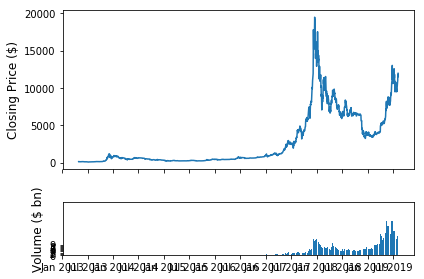

In [56]:

fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2020) for j in [1,7]])
ax1.plot(bitcoin_market_info['Date'].dt.to_pydatetime(),bitcoin_market_info['bt_Open*'])
ax2.bar(bitcoin_market_info['Date'].dt.to_pydatetime(), bitcoin_market_info['bt_Volume'].values)
fig.tight_layout()
plt.show()

In [57]:
print(bitcoin_market_info.shape)

(2294, 7)


In [58]:
market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
print(market_info.shape)
market_info = market_info[market_info['Date']>='2016-01-01']
print(market_info.shape)
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close**']-x[coins+'Open*'])/x[coins+'Open*']}
    market_info = market_info.assign(**kwargs)


(1463, 13)
(1316, 13)


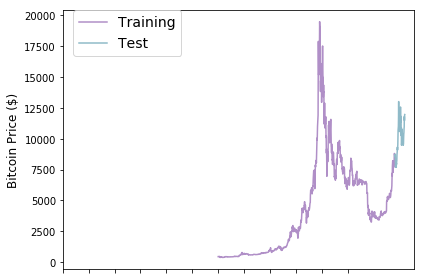

In [59]:
split_date = '2019-06-01'
fig, (ax1) = plt.subplots(1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].dt.to_pydatetime(),
         market_info[market_info['Date'] < split_date]['bt_Close**'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].dt.to_pydatetime(),
         market_info[market_info['Date'] >= split_date]['bt_Close**'], 
         color='#8FBAC8', label='Test')

ax1.set_xticklabels('')
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)

plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [60]:
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close**'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open*'])}
    market_info = market_info.assign(**kwargs)

In [61]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_', 'eth_'] 
                                   for metric in ['Close**','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close**,bt_Volume,bt_close_off_high,bt_volatility,eth_Close**,eth_Volume,eth_close_off_high,eth_volatility
1315,2016-01-01,434.33,36278900,-0.560137,0.020268,0.948024,206062,-0.418477,0.025040
1314,2016-01-02,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913
1313,2016-01-03,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792
1312,2016-01-04,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943
1311,2016-01-05,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236


In [62]:
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date',1)
test_set = test_set.drop('eth_Close**')
test_set = test_set.drop('eth_close_off_high')
test_set = test_set.drop('eth_volatility')
test_set = test_set.drop('eth_Volume')

In [63]:
test_set.head(5)

,bt_Close**,bt_Volume,bt_close_off_high,bt_volatility,eth_Close**,eth_Volume,eth_close_off_high,eth_volatility
68,8564.02,22488303544,-0.144841,0.016798,265.39,9942869852,0.627490,0.037403
67,8742.96,20266216022,-0.465129,0.028960,270.23,8744111713,-0.335907,0.029264
66,8208.99,22004511436,0.982199,0.061694,252.61,9375712917,0.858416,0.070606
65,7707.77,24609731549,0.556752,0.078736,241.34,10132549747,0.363858,0.064869
64,7824.23,21760923463,-0.334248,0.030266,247.05,8548917062,-0.732843,0.033789


In [64]:
window_len = 5
norm_cols = [coin+metric for coin in ['bt_', 'eth_'] for metric in ['Close**','Volume']]
# training set
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['bt_Close**'][window_len:].values/training_set['bt_Close**'][:-window_len].values)-1

#test set
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['bt_Close**'][window_len:].values/test_set['bt_Close**'][:-window_len].values)-1

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [65]:
print(training_set.shape)
print(LSTM_training_inputs.shape)

print(test_set.shape)
print(LSTM_test_inputs[0].shape)

(1247, 8)
(1242, 5, 8)
(69, 8)
(5, 8)


In [66]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(256, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [67]:
# random seed 
np.random.seed(123)
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)


LSTM_training_outputs = (training_set['bt_Close**'][window_len:].values/training_set['bt_Close**'][:-window_len].values)-1
# train model on data

bt_history = bt_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 27s - loss: 0.0542
Epoch 2/50
 - 22s - loss: 0.0393
Epoch 3/50
 - 20s - loss: 0.0367
Epoch 4/50
 - 24s - loss: 0.0344
Epoch 5/50
 - 22s - loss: 0.0341
Epoch 6/50
 - 23s - loss: 0.0344
Epoch 7/50
 - 22s - loss: 0.0338
Epoch 8/50
 - 22s - loss: 0.0331
Epoch 9/50
 - 27s - loss: 0.0326
Epoch 10/50
 - 23s - loss: 0.0332
Epoch 11/50
 - 23s - loss: 0.0321
Epoch 12/50
 - 23s - loss: 0.0322
Epoch 13/50
 - 29s - loss: 0.0309
Epoch 14/50
 - 24s - loss: 0.0323
Epoch 15/50
 - 25s - loss: 0.0318
Epoch 16/50
 - 24s - loss: 0.0313
Epoch 17/50
 - 24s - loss: 0.0316
Epoch 18/50
 - 26s - loss: 0.0321
Epoch 19/50
 - 25s - loss: 0.0319
Epoch 20/50
 - 23s - loss: 0.0313
Epoch 21/50
 - 25s - loss: 0.0308
Epoch 22/50
 - 24s - loss: 0.0306
Epoch 23/50
 - 24s - loss: 0.0314
Epoch 24/50
 - 23s - loss: 0.0310
Epoch 25/50
 - 23s - loss: 0.0307
Epoch 26/50
 - 22s - loss: 0.0301
Epoch 27/50
 - 24s - loss: 0.0306
Epoch 28/50
 - 24s - loss: 0.0312
Epoch 29/50
 - 25s - loss: 0.0304
Epoch 30/50
 - 26s - lo

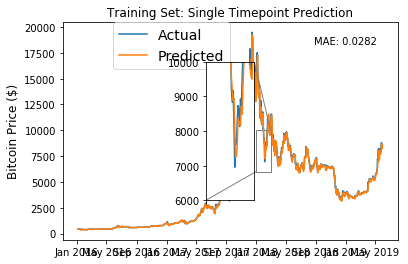

In [68]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2020) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].dt.to_pydatetime(),
         training_set['bt_Close**'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].dt.to_pydatetime(),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close**'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_Close**'].values[window_len:])/(training_set['bt_Close**'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')


axins = zoomed_inset_axes(ax1, 3.35, loc=10) # zoom-factor: 2.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].dt.to_pydatetime(),
         training_set['bt_Close**'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].dt.to_pydatetime(),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close**'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2018, 1, 1), datetime.date(2018, 3, 1)])
axins.set_ylim([6000,10000])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

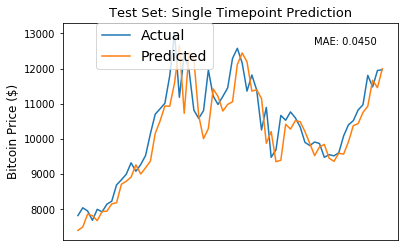

In [69]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].dt.to_pydatetime(),
         test_set['bt_Close**'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].dt.to_pydatetime(),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close**'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_Close**'].values[window_len:])/(test_set['bt_Close**'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()


In [70]:
import pandas as pd
from pandas import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.api import tsa

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [71]:
data  = bitcoin_market_info
print(data.shape)
data.tail()

(2294, 7)


,Date,bt_Open*,bt_High,bt_Low,bt_Close**,bt_Volume,bt_Market Cap
2289,2013-05-02,116.38,125.60,92.28,105.21,0,1168517495
2290,2013-05-01,139.00,139.89,107.72,116.99,0,1298954594
2291,2013-04-30,144.00,146.93,134.05,139.00,0,1542813125
2292,2013-04-29,134.44,147.49,134.00,144.54,0,1603768865
2293,2013-04-28,135.30,135.98,132.10,134.21,0,1488566728


In [72]:
data['Date'] = data['Date'].dt.date
data.set_index(pd.to_datetime(data['Date']), inplace=True)
data.drop('Date', axis=1, inplace=True)
data.head()

,bt_Open*,bt_High,bt_Low,bt_Close**,bt_Volume,bt_Market Cap
Date,,,,,,
2019-08-08,11954.04,11979.42,11556.17,11966.41,19481591730,213788089212
2019-08-07,11476.19,12036.99,11433.70,11941.97,22194988641,213330426789
2019-08-06,11811.55,12273.82,11290.73,11478.17,23635107660,205023347814
2019-08-05,10960.74,11895.09,10960.74,11805.65,23875988832,210848822060
2019-08-04,10821.63,11009.21,10620.28,10970.18,16530894787,195907875403


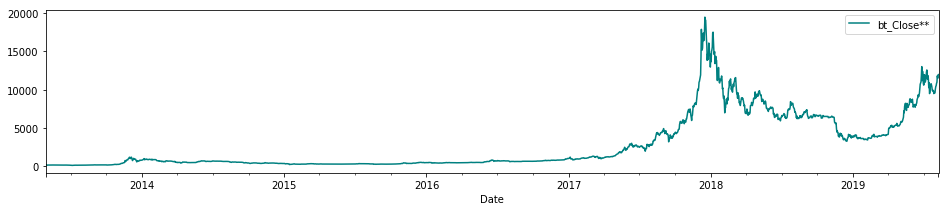

In [73]:
data.plot(y='bt_Close**', color='teal', figsize=(16,3))

In [74]:


price_weekly_avg = data.resample('W').apply(np.mean)
price_monthly_avg = data.resample('M').apply(np.mean)

In [75]:
price_weekly_avg.head(5)

,bt_Open*,bt_High,bt_Low,bt_Close**,bt_Volume,bt_Market Cap
Date,,,,,,
2013-04-28,135.300000,135.980000,132.100000,134.210000,0.0,1.488567e+09
2013-05-05,121.581429,128.834286,106.684286,118.842857,0.0,1.319866e+09
2013-05-12,113.881429,117.924286,108.741429,113.925714,0.0,1.268553e+09
2013-05-19,117.620000,121.160000,114.127143,118.708571,0.0,1.325205e+09
2013-05-26,126.085714,128.660000,124.524286,127.732857,0.0,1.429371e+09


In [76]:
price_weekly_avg = price_weekly_avg.rename(columns={'bt_Close**': 'Price'})
price_monthly_avg = price_monthly_avg.rename(columns={'bt_Close**': 'Price'})
data = data.rename(columns={'bt_Close**': 'Price'})

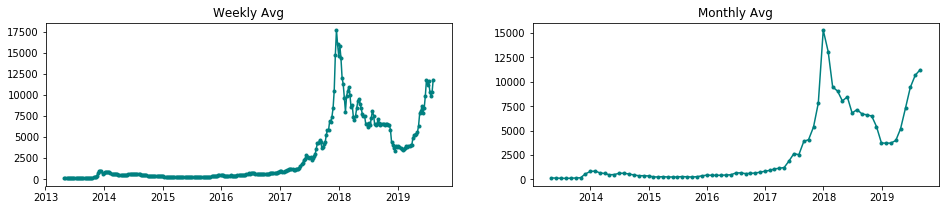

In [77]:
plt.figure(figsize=(16,3))
plt.subplot(121)
plt.title('Weekly Avg')
plt.plot(price_weekly_avg.Price, "-o", markersize=3, color='teal')
plt.subplot(122)
plt.title('Monthly Avg')
plt.plot(price_monthly_avg.Price, "-o", markersize=3, color='teal')

Text(0, 0.5, 'Autocorrelation')

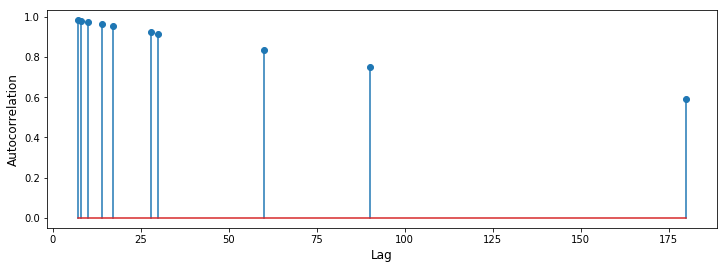

In [78]:
lags = [7, 8, 10, 15, 18, 29, 30, 60, 90, 180] 
autocorrs = [data.Price.autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(12, 4))
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)

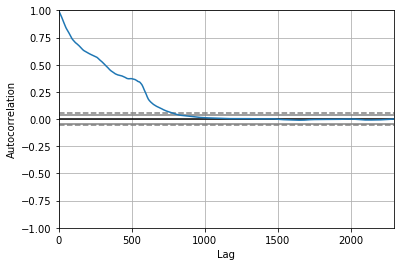

In [79]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data)

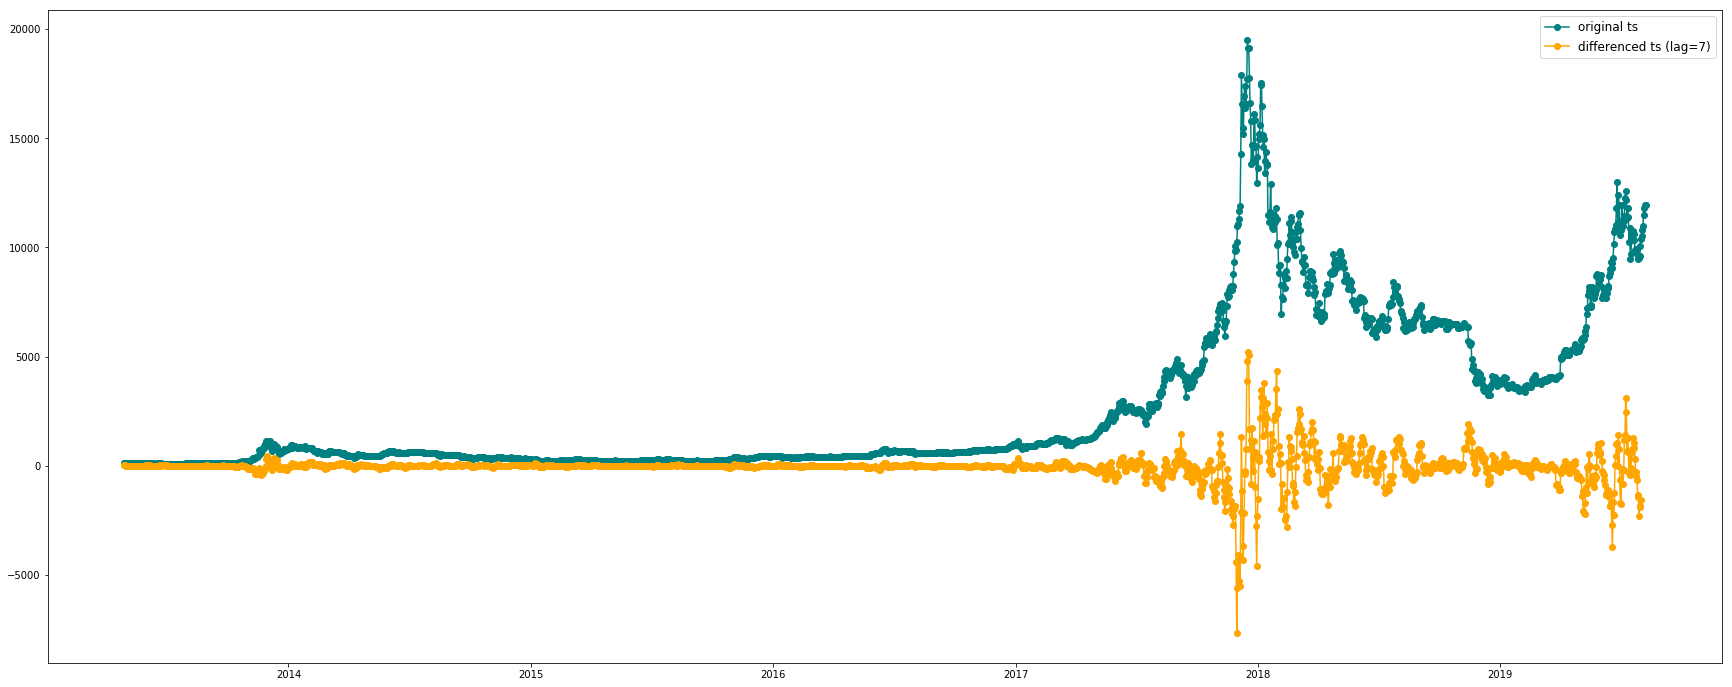

In [80]:
plt.figure(figsize=(30, 12))
plt.plot(data.Price, '-o', color='teal', label="original ts")
plt.plot(data.Price.diff(7), '-o', color='orange', label="differenced ts (lag=7)")
plt.legend(fontsize=12)

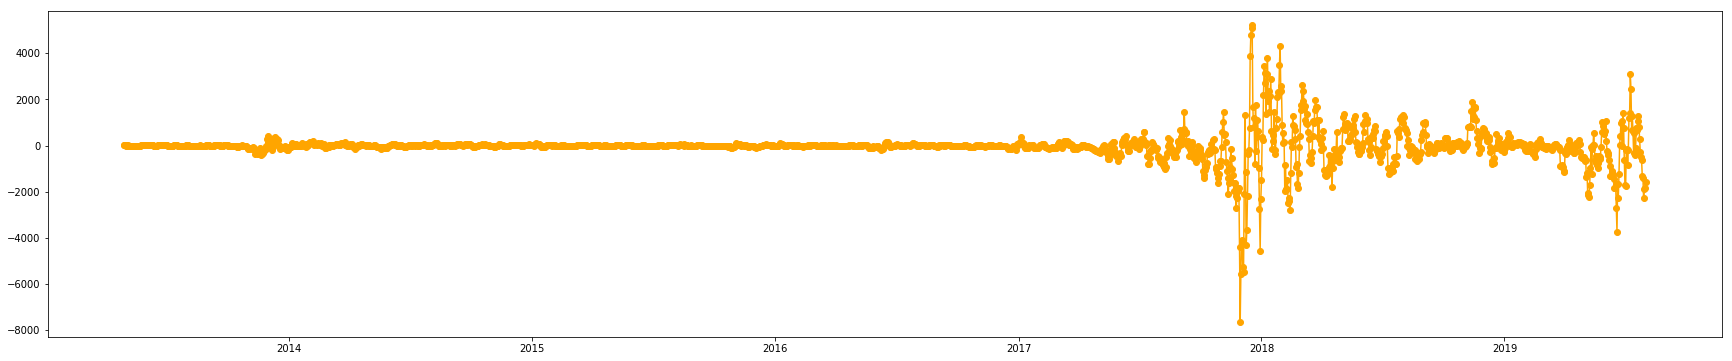

In [81]:
prices = data.Price
price_diff = prices.diff(7).dropna() 

plt.figure(figsize=(30,6))
plt.plot(price_diff, "-o", color='orange')

In [82]:
time_series = price_diff

In [83]:
def organize_data(to_forecast, window, horizon=1):
    
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast,
                                        shape=shape,
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

lag = 90
X, y = organize_data(time_series, lag)

C:\Users\chira\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Series.strides is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


MAE_day = 88.761
MAE_week = 10.437
MAE_month = 5.517
MAE_year = 26.501


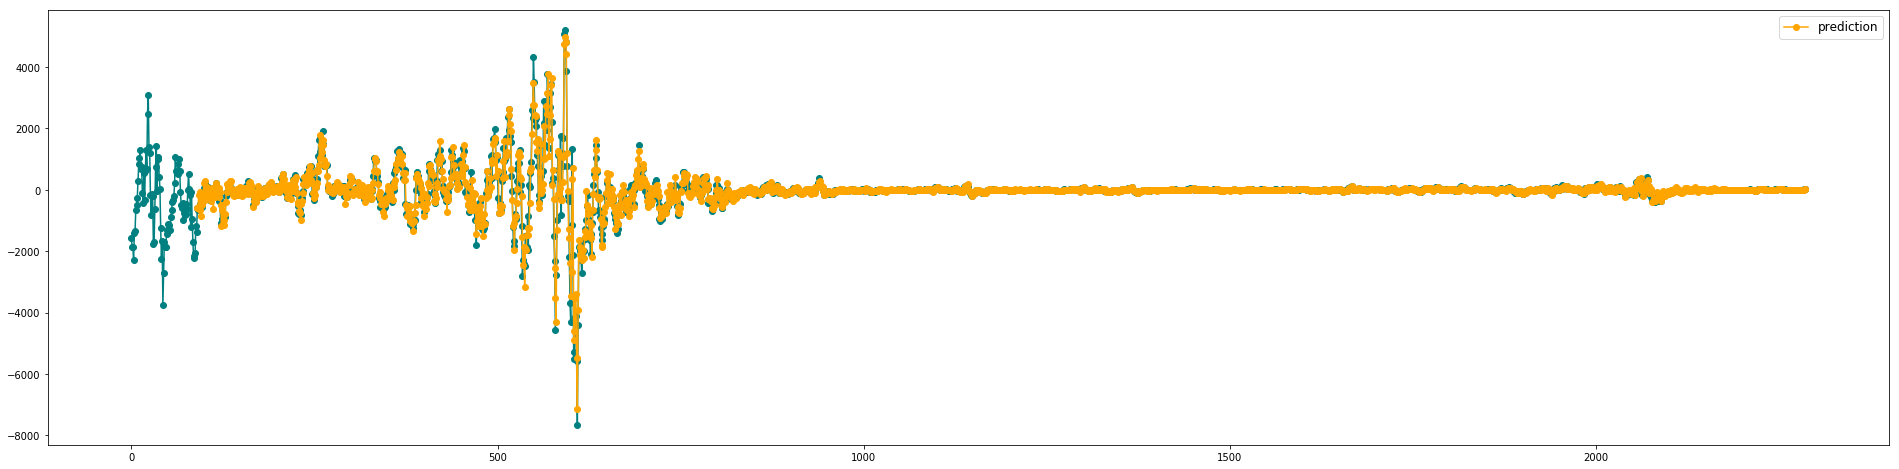

In [97]:
lr = LinearRegression()
lr_fit = lr.fit(X, y)
lr_prediction = lr_fit.predict(X)

plt.figure(figsize=(33, 8))
plt.plot(time_series.values, '-o', color='teal')
plt.plot(np.arange(lag, len(time_series)), lr_prediction, '-o', label='prediction', color='orange')
plt.legend(fontsize=12);

print('MAE_day = {0:.3f}'.format(mean_absolute_error(time_series[lag:], lr_prediction)))
print('MAE_week = {0:.3f}'.format(mean_absolute_error(time_series[-7:], lr_prediction[-7:]))) #for last 1 week
print('MAE_month = {0:.3f}'.format(mean_absolute_error(time_series[-30:], lr_prediction[-30:]))) #for last 1 month
print('MAE_year = {0:.3f}'.format(mean_absolute_error(time_series[-365:], lr_prediction[-365:]))) #for last 1 year

In [85]:
ar = tsa.AR(time_series)
optlag = ar.select_order(100, ic='aic') 
print("Best optimal lag for ar model: {}".format(optlag))

C:\Users\chira\Anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
C:\Users\chira\Anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


KeyboardInterrupt: 

C:\Users\chira\Anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
C:\Users\chira\Anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


MAE = 94.702
MAE_week = 10.584
MAE_month = 5.718
MAE_year = 23.783


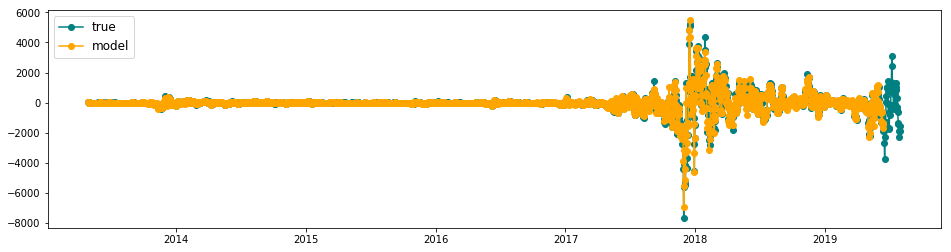

In [102]:
lag = 47 
ar = tsa.AR(time_series)
ar_fit = ar.fit(maxlag=lag, ic='aic')
ar_prediction = ar_fit.predict(start=lag)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(ar_prediction, '-o', label='model', color='orange')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[lag:], ar_prediction)))
print('MAE_week = {0:.3f}'.format(mean_absolute_error(time_series[-7:], ar_prediction[-7:]))) #error only for the last 7 days
print('MAE_month = {0:.3f}'.format(mean_absolute_error(time_series[-30:], ar_prediction[-30:]))) #error only for the last 30 days
print('MAE_year = {0:.3f}'.format(mean_absolute_error(time_series[-365:], ar_prediction[-365:]))) #error only for the last 365 days


C:\Users\chira\Anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
C:\Users\chira\Anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


MAE = 87.194
MAE2 = 12.453
MAE2 = 7.400
MAE2 = 21.101


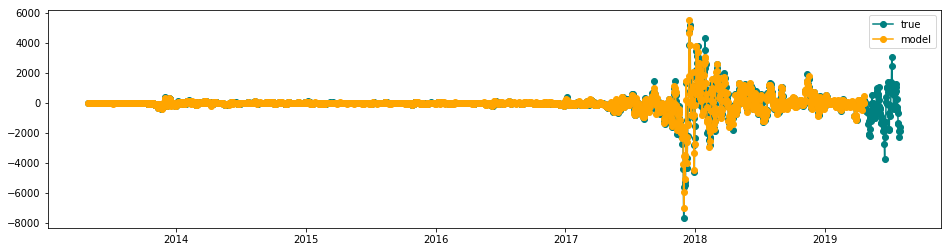

In [104]:
arma = tsa.ARMA(time_series, order=(7, 7)) #7 p and 7 q for lag and moving average 
arma_fit = arma.fit()
start=100
arma_prediction = arma_fit.predict(start=start)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(arma_prediction, '-o', label='model', color='orange')
plt.legend();

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[start:], arma_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-7:], arma_prediction[-7:])))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-30:], arma_prediction[-30:])))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-365:], arma_prediction[-365:])))#error only for the last 90 days

In [105]:
 
lag = 47
ar = tsa.AR(time_series)
ar_fit = ar.fit(maxlag=lag)
ar_forecast = ar_fit.predict(end=len(time_series)+6)[-7:] 
ar_forecast

C:\Users\chira\Anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
C:\Users\chira\Anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\chira\Anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\chira\Anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


2013-04-27    17.364415
2013-04-26    26.744547
2013-04-25    17.056395
2013-04-24     4.550623
2013-04-23   -19.186682
2013-04-22   -25.906524
2013-04-21   -17.634369
Freq: -1D, dtype: float64

In [106]:
#7 out of sample prediction with ARMA
arma = tsa.ARMA(time_series, order=(7, 7)) 
arma = arma.fit()
arma_forecast = arma.predict(end=len(time_series)+6)[-7:]
arma_forecast

C:\Users\chira\Anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)


2013-04-27     6.051625
2013-04-26    18.183874
2013-04-25    19.192026
2013-04-24     0.175734
2013-04-23   -26.461495
2013-04-22   -31.711464
2013-04-21   -26.589433
Freq: -1D, dtype: float64

In [107]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(time_series, order=(7,0,7))
arima_fit = model.fit()
arima_forecast= arima_fit.forecast(steps=7)[0]
arima_forecast

C:\Users\chira\Anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)


array([  6.05162539,  18.18387417,  19.19202558,   0.17573404,
       -26.46149543, -31.71146416, -26.58943282])

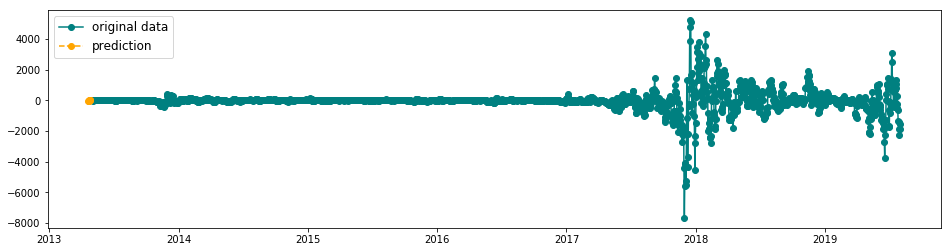

In [108]:
#AR model's 7 out of sample predictions
plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(ar_forecast, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)

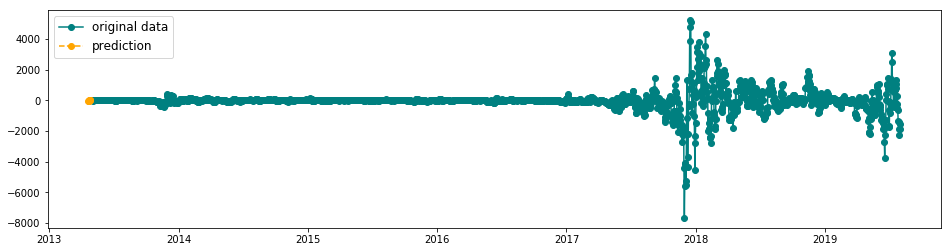

In [110]:
#ARMA model's 7 out sample predicitons 
plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(arma_forecast, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)

In [111]:

print(prices[-7:])

Date
2013-05-04    112.50
2013-05-03     97.75
2013-05-02    105.21
2013-05-01    116.99
2013-04-30    139.00
2013-04-29    144.54
2013-04-28    134.21
Name: Price, dtype: float64


In [112]:
idx = ar_forecast.index.values

forecast_prices = []
lag = 7
for i, diff in enumerate(ar_forecast): #choosing AR as it produced lower MAE than ARMA model
    prev_value = prices[-(lag)+i:][0]
    forecast_prices.append(prev_value+diff)
    
bitcoin_forecast = pd.Series(forecast_prices, index=idx)
bitcoin_forecast

2013-04-27    129.864415
2013-04-26    124.494547
2013-04-25    122.266395
2013-04-24    121.540623
2013-04-23    119.813318
2013-04-22    118.633476
2013-04-21    116.575631
dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

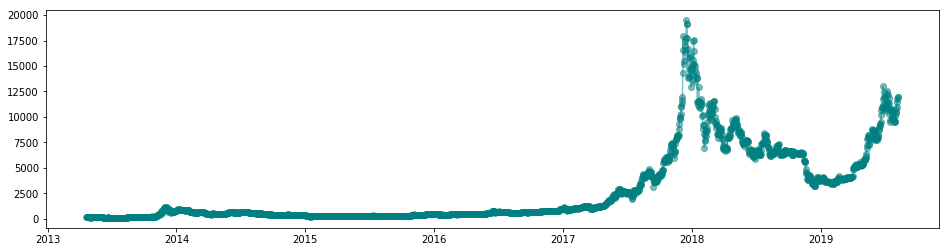

In [113]:
hist_values = data['Price'].append(bitcoin_forecast)

plt.figure(figsize=(16,4))
plt.plot(hist_values, '-o', color='teal', alpha=0.5)
plt.show

In [114]:
real_price = pd.DataFrame(data={"price":[8556.61, 8070.8, 8891.21, 8516.24, 9477.84, 10016.49, 10178.71],
                          "dates":['2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15',
                               '2018-02-16']})

real_price.set_index(pd.to_datetime(real_price['dates']), inplace=True)
real_price.drop('dates', axis=1, inplace=True)
real_price

,price
dates,
2018-02-10,8556.61
2018-02-11,8070.80
2018-02-12,8891.21
2018-02-13,8516.24
2018-02-14,9477.84
2018-02-15,10016.49
2018-02-16,10178.71


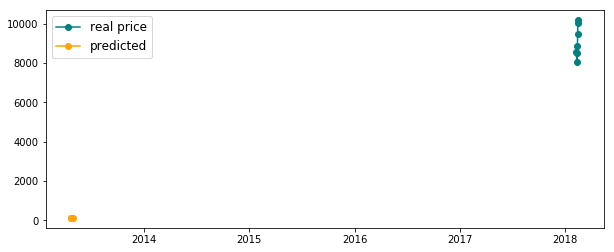

In [115]:
plt.figure(figsize=(10,4))
plt.plot(real_price, "-o", color="teal", label="real price")
plt.plot(bitcoin_forecast, "-o", color="orange", label="predicted")
plt.legend(fontsize=12)
plt.show()